In [1]:
import os
from pathlib import Path
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [9]:
#print current working directory
print(os.getcwd())
repo_path = os.getcwd()

d:\VS_Projects\MIRA_MISA_LABS\MISA_LAB3


## Tissue models: segmentation using just intensity information

In [10]:
# load the tissue models
tm = pd.read_pickle(str(repo_path) + f'/data/our_tissue_models/tissue_model.p')

In [11]:
tm[1950]

array([0. , 0.5, 0.5])

# Read new test images to perform the segmentation

In [14]:
# Read patients in the test-set:
test_set_path = 'data/testing-set'
aux_patients_list = os.listdir(test_set_path + '/testing-images')
list_patient = []
for str1 in aux_patients_list:
    list_patient.append(str1.replace(".nii.gz", ""))

In [15]:
## Preprocessing -- skull removal step
def skull_removal(img, mask):
    brain_mask = mask>=1
    skull_strip = img*(brain_mask)
    return skull_strip

In [16]:
# save the array as a new nifti image
def save_as_nifti(array, filename, reference_image):
    """Save array as nifti image

    Args:
        array (array): array to be saved
        filename (str): path to save
        reference_image (str): path of reference image
    """
    reference_image = sitk.ReadImage(reference_image)
    image = sitk.GetImageFromArray(array)
    image.SetOrigin(reference_image.GetOrigin())
    image.SetSpacing(reference_image.GetSpacing())
    image.SetDirection(reference_image.GetDirection())
    sitk.WriteImage(image, filename)

In [18]:
def get_tissue_model_seg(list_patient, tm):
    arr_seg_imgs =[]
    # read images for each patient one by one
    for p in tqdm(list_patient):
        im_path = str(repo_path) + f'/data/testing-set/testing-images/{p}.nii.gz'
        mask_path = str(repo_path) + f'/data/testing-set/testing-labels/{p}_3C.nii.gz'
        img_array1 = sitk.GetArrayFromImage(sitk.ReadImage(str(im_path)))
        label_array1 = sitk.GetArrayFromImage(sitk.ReadImage(str(mask_path)))

        # Preprocessing - skull stripping
        img_array = skull_removal(img_array1, label_array1)

        # check the image maximum intensity
        max_value = int(np.max(img_array))
        max_value = max_value+1

        # get the maximum among the tissue
        lookup_table = np.argmax(tm, axis=1) # the matching with intensity and tissue

        if max_value > len(lookup_table):
            # extend the lookup table accordingly.
            zeros = np.zeros(max_value-len(lookup_table)+1)
            lookup_table = np.append(lookup_table, np.array(zeros) ) # the filling for the exceptional intensities.

        array_int = np.array(img_array, dtype="uint16")
        new_img = lookup_table[array_int] #matching with the lookup table vs test images

        # save the segmented image as a nifti image
        # save_as_nifti(new_img, str(repo_path) + f'/data/tm_seg_{p}.nii', im_path)

        arr_seg_imgs.append(new_img)

    return arr_seg_imgs

In [19]:
arr_seg_imgs = get_tissue_model_seg(list_patient, tm)

100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


In [20]:
def show_segmented_img(img_list):
    for im in img_list:
        plt.imshow(im[150], cmap = "gray")

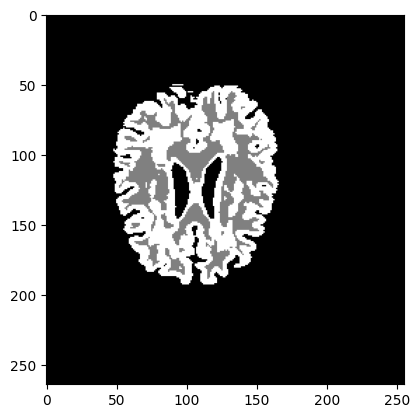

In [22]:
show_segmented_img(arr_seg_imgs)

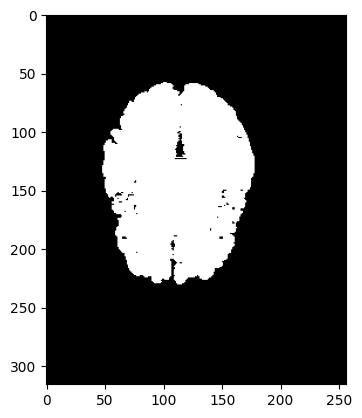

In [36]:
label_array1 = str(repo_path) + f'/data/testing-set/testing-labels/{list_patient[0]}_3C.nii.gz'
label_array2 = sitk.GetArrayFromImage(sitk.ReadImage(str(label_array1)))
image_1 = arr_seg_imgs[0]

plt.imshow(image_1[150], cmap = "gray")

In [37]:
arr_seg_imgs[0].shape

(256, 316, 256)